In [2]:
#@title Step 1: Setup Environment and Import Libraries ▶️
# ==============================================================================
# Step 1: Professional Setup and Environment Checks
# ==============================================================================
print("Step 1: Setting up the environment...")
# Check for GPU - THIS SHOULD NOW SHOW A GPU
!nvidia-smi -L || echo "CRITICAL WARNING: No GPU found."

# Install necessary packages quietly
!pip install -q opendatasets split-folders

# Import all necessary libraries
import os, shutil, random
import numpy as np
import tensorflow as tf
import opendatasets as od
import splitfolders
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("\nTensorFlow version:", tf.__version__)
print("GPUs visible to TensorFlow:", tf.config.list_physical_devices('GPU'))
print("\n✅ Environment setup complete.")

Step 1: Setting up the environment...
GPU 0: Tesla T4 (UUID: GPU-e6bf85f4-ae9d-9ff8-f78a-b873b69e25cf)

TensorFlow version: 2.19.0
GPUs visible to TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✅ Environment setup complete.


In [3]:
#@title Step 2: Download and Prepare Dataset ▶️
# ==============================================================================
# Step 2: Create Folders, Download and Preprocess Dataset
# ==============================================================================
print("Step 2: Preparing folders and dataset...")
DATA_ROOT, SPLIT_ROOT, ARTIFACTS_DIR = "/content/data", "/content/tea_splits", "/content/artifacts"
os.makedirs(DATA_ROOT, exist_ok=True); os.makedirs(SPLIT_ROOT, exist_ok=True); os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Download the dataset from Kaggle
dataset_url = "https://www.kaggle.com/datasets/uthpalabandara/common-diseases-of-tea-leaves-in-sri-lanka"
od.download(dataset_url, data_dir=DATA_ROOT)

# Define the path to the downloaded data
original_data_dir = os.path.join(DATA_ROOT, "common-diseases-of-tea-leaves-in-sri-lanka")

# Fix the nested folder structure
print("\nFixing dataset folder structure...")
for class_folder in os.listdir(original_data_dir):
    class_path = os.path.join(original_data_dir, class_folder)
    if os.path.isdir(class_path):
        inner_path = os.path.join(class_path, class_folder)
        if os.path.exists(inner_path) and os.path.isdir(inner_path):
            for file_name in os.listdir(inner_path): shutil.move(os.path.join(inner_path, file_name), class_path)
            shutil.rmtree(inner_path)

print("\n✅ Dataset downloaded and prepared.")

Step 2: Preparing folders and dataset...
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chathuminakaushal11
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/uthpalabandara/common-diseases-of-tea-leaves-in-sri-lanka


100%|██████████| 960M/960M [00:07<00:00, 135MB/s] 




Fixing dataset folder structure...

✅ Dataset downloaded and prepared.


In [4]:
#@title Step 3: Split Dataset (70-20-10 ratio) ▶️
# ==============================================================================
# Step 3: Split data into train, validation, and test sets
# ==============================================================================
print("Step 3: Splitting dataset into train, validation, and test sets...")

splitfolders.ratio(
    original_data_dir,
    output=SPLIT_ROOT,
    seed=SEED,
    ratio=(0.7, 0.2, 0.1), # 70% train, 20% validation, 10% test
    move=False # Copy files
)

# Define the final paths for each set
train_dir = os.path.join(SPLIT_ROOT, "train")
val_dir = os.path.join(SPLIT_ROOT, "val")
test_dir = os.path.join(SPLIT_ROOT, "test")

print(f"\nDataset split into three folders located at: {SPLIT_ROOT}")
print(f" - Training images: {len(os.listdir(train_dir))}")
print(f" - Validation images: {len(os.listdir(val_dir))}")
print(f" - Test images: {len(os.listdir(test_dir))}")
print("\n✅ Dataset splitting complete.")

Step 3: Splitting dataset into train, validation, and test sets...


Copying files: 1196 files [00:07, 164.21 files/s]


Dataset split into three folders located at: /content/tea_splits
 - Training images: 8
 - Validation images: 8
 - Test images: 8

✅ Dataset splitting complete.


In [5]:
#@title Step 4: Configure Image Data Generators ▶️
# ==============================================================================
# Step 4: Define Data Generators
# ==============================================================================
print("Step 4: Defining data generators...")

IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE = 224, 224, 32
INITIAL_EPOCHS = 10 # Train head for 10 epochs
FINE_TUNE_EPOCHS = 15 # Fine-tune for 15 more epochs

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Only rescale for validation and test sets (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create the generator objects
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)
validation_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)
test_generator = val_datagen.flow_from_directory(
    test_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"\nClasses found: {class_names}")
print("\n✅ Data generators created.")

Step 4: Defining data generators...
Found 835 images belonging to 8 classes.
Found 236 images belonging to 8 classes.
Found 125 images belonging to 8 classes.

Classes found: ['Algal Leaf', 'Anthracnose', 'Bird Eye Spot', 'Brown Blight', 'Gray Light', 'Healthy', 'Red Leaf Spot', 'White Spot']

✅ Data generators created.


In [6]:
#@title Step 5: Build and Train the MobileNetV2 Model ▶️
# ==============================================================================
# Step 5 & 6 & 7 & 8: Build and Train the Model (Two Stages)
# ==============================================================================

# --- STAGE 1: Build and train the head ---
print("--- STAGE 1: Building and training the model head ---")
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
base_model.trainable = False # Base model is FROZEN

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting Stage 1 training for {INITIAL_EPOCHS} epochs...")
history_initial = model.fit(train_generator, epochs=INITIAL_EPOCHS, validation_data=validation_generator)
print("\n✅ Stage 1 training finished.")

# --- STAGE 2: Fine-tune the model ---
print("\n\n--- STAGE 2: Preparing for fine-tuning ---")
base_model.trainable = True # UNFREEZE the base model

# Freeze all layers except for the top 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Re-compile the model with a very low learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
print("Model re-compiled for fine-tuning.")

print(f"\nStarting Stage 2 fine-tuning for {FINE_TUNE_EPOCHS} more epochs...")
total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
history_finetune = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history_initial.epoch[-1], # Continue from where we left off
    validation_data=validation_generator
)
print("\n✅ Model training complete.")

--- STAGE 1: Building and training the model head ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Starting Stage 1 training for 10 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.3608 - loss: 2.0431 - val_accuracy: 0.6864 - val_loss: 0.8679
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6269 - loss: 0.9540 - val_accuracy: 0.6610 - val_loss: 0.7890
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6605 - loss: 0.8648 - val_accuracy: 0.7754 - val_loss: 0.6194
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7355 - loss: 0.7079 - val_accuracy: 0.7161 - val_loss: 0.7562
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7439 - loss: 0.6576 - val_accuracy: 0.7712 - val_loss: 0.6588
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7625 - loss: 0.6523 - val_accuracy: 0.7966 - val_loss: 0.5659
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7724 - loss: 0.5702 - val_accuracy: 0.8008 - val_loss: 0.5560
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7959 - loss: 0.5568 - val_accuracy: 0.7373 - val_loss:

Step 6: Evaluating final model performance...


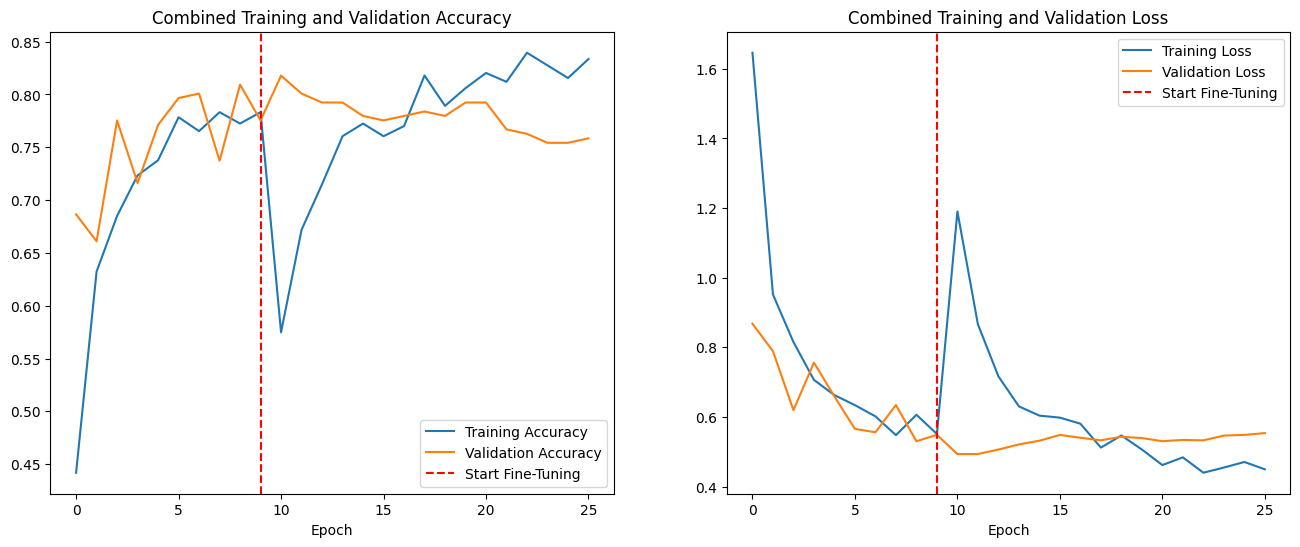


--- Evaluating on the unseen test set ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.6748 - loss: 0.7981

Final Test Accuracy: 75.20%
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step

--- Final Classification Report (on Test Set) ---

               precision    recall  f1-score   support

   Algal Leaf       1.00      0.62      0.77        16
  Anthracnose       0.67      0.29      0.40        14
Bird Eye Spot       0.52      0.93      0.67        14
 Brown Blight       0.71      0.80      0.75        15
   Gray Light       0.85      0.79      0.81        14
      Healthy       1.00      0.80      0.89        10
Red Leaf Spot       1.00      0.78      0.88        23
   White Spot       0.64      0.95      0.77        19

     accuracy                           0.75       125
    macro avg       0.80      0.74      0.74       125
 weighted avg       0.80      0.75      0.75       125


--- Final Confusion Matrix (on Test Set) ---



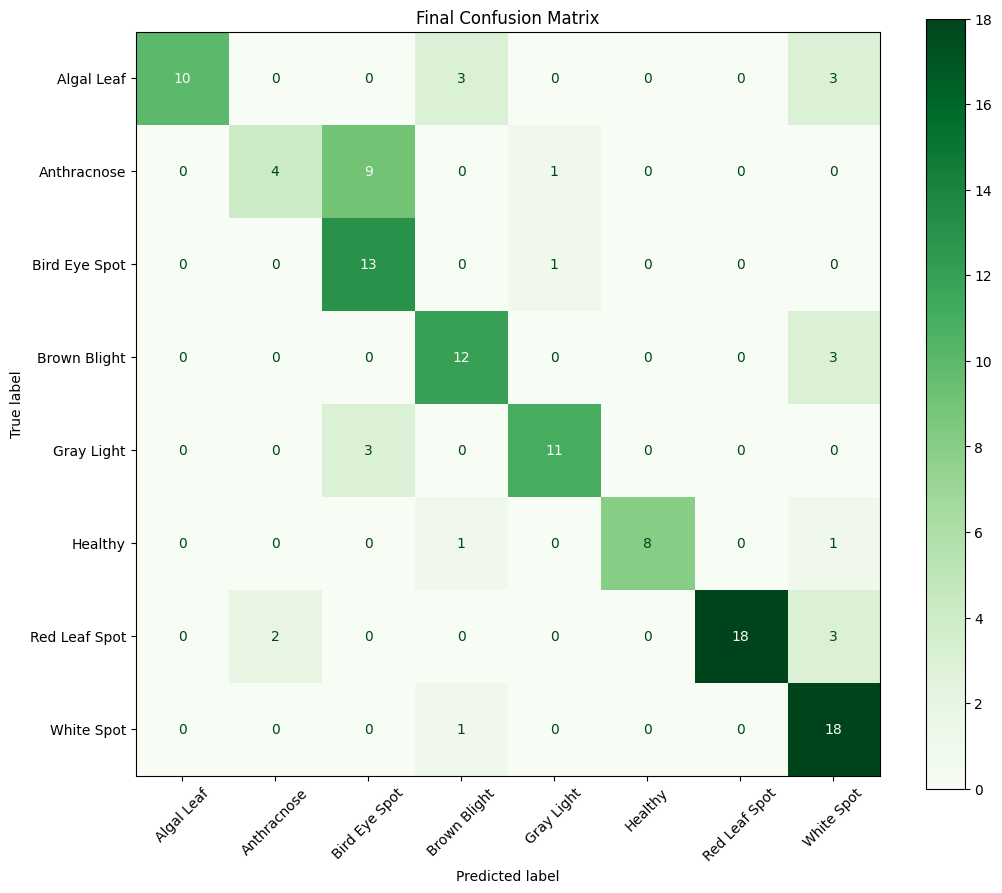

In [7]:
#@title Step 6: Evaluate Performance and Visualize Results ▶️
# ==============================================================================
# Step 9: Evaluate and Visualize Final Performance
# ==============================================================================
print("Step 6: Evaluating final model performance...")

# Combine histories for plotting
acc = history_initial.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_initial.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history_initial.history['loss'] + history_finetune.history['loss']
val_loss = history_initial.history['val_loss'] + history_finetune.history['val_loss']

# Plot Accuracy and Loss Graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(acc, label='Training Accuracy'); ax1.plot(val_acc, label='Validation Accuracy')
ax1.axvline(x=INITIAL_EPOCHS-1, color='r', linestyle='--', label='Start Fine-Tuning')
ax1.legend(loc='lower right'); ax1.set_title('Combined Training and Validation Accuracy')
ax1.set_xlabel('Epoch')

ax2.plot(loss, label='Training Loss'); ax2.plot(val_loss, label='Validation Loss')
ax2.axvline(x=INITIAL_EPOCHS-1, color='r', linestyle='--', label='Start Fine-Tuning')
ax2.legend(loc='upper right'); ax2.set_title('Combined Training and Validation Loss')
ax2.set_xlabel('Epoch')
plt.savefig(os.path.join(ARTIFACTS_DIR, "final_training_graphs.png")); plt.show()

# Evaluate on the unseen test set
print("\n--- Evaluating on the unseen test set ---")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nFinal Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate Classification Report
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
print("\n--- Final Classification Report (on Test Set) ---\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generate Confusion Matrix
print("\n--- Final Confusion Matrix (on Test Set) ---\n")
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax=ax, xticks_rotation=45, cmap='Greens')
plt.title('Final Confusion Matrix');
plt.savefig(os.path.join(ARTIFACTS_DIR, "final_confusion_matrix.png"));
plt.show()

Step 7: Saving and testing the final model...
Model saved successfully to: /content/artifacts/mobilenetv2_finetuned_model.h5



--- Testing on a single random image ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


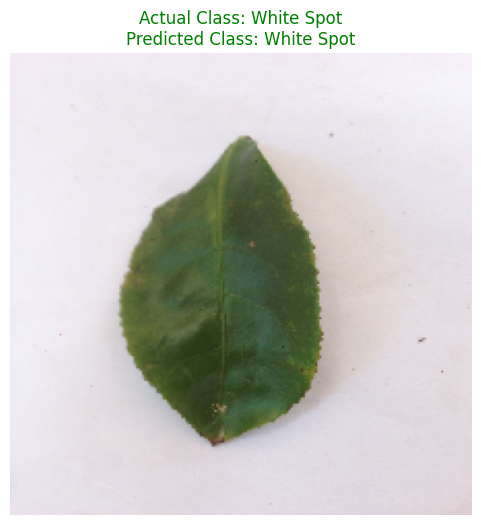

✅ Single image test complete.


In [8]:
#@title Step 7: Save Model and Test a Single Image ▶️
# ==============================================================================
# Step 10: Save and Test the Final Model
# ==============================================================================
print("Step 7: Saving and testing the final model...")

# Save the model
model_path = os.path.join(ARTIFACTS_DIR, "mobilenetv2_finetuned_model.h5")
model.save(model_path)
print(f"Model saved successfully to: {model_path}")

# Load the model back
saved_model = load_model(model_path)
print("\n--- Testing on a single random image ---")

# Choose a random image
random_class = random.choice(os.listdir(test_dir))
random_image_name = random.choice(os.listdir(os.path.join(test_dir, random_class)))
image_path = os.path.join(test_dir, random_class, random_image_name)

# Preprocess and predict
img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
img_array = img_to_array(img)
img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0
prediction_probs = saved_model.predict(img_array_expanded)
predicted_class_name = class_names[np.argmax(prediction_probs)]

# Display the result
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Actual Class: {random_class}\nPredicted Class: {predicted_class_name}",
          color=("green" if random_class == predicted_class_name else "red"))
plt.axis("off")
plt.show()

print("✅ Single image test complete.")

Loading trained model from Google Drive...


Model '/content/artifacts/mobilenetv2_finetuned_model.h5' loaded successfully.

Displaying predictions for 16 random test images...
Green = Correct Prediction, Red = Incorrect Prediction


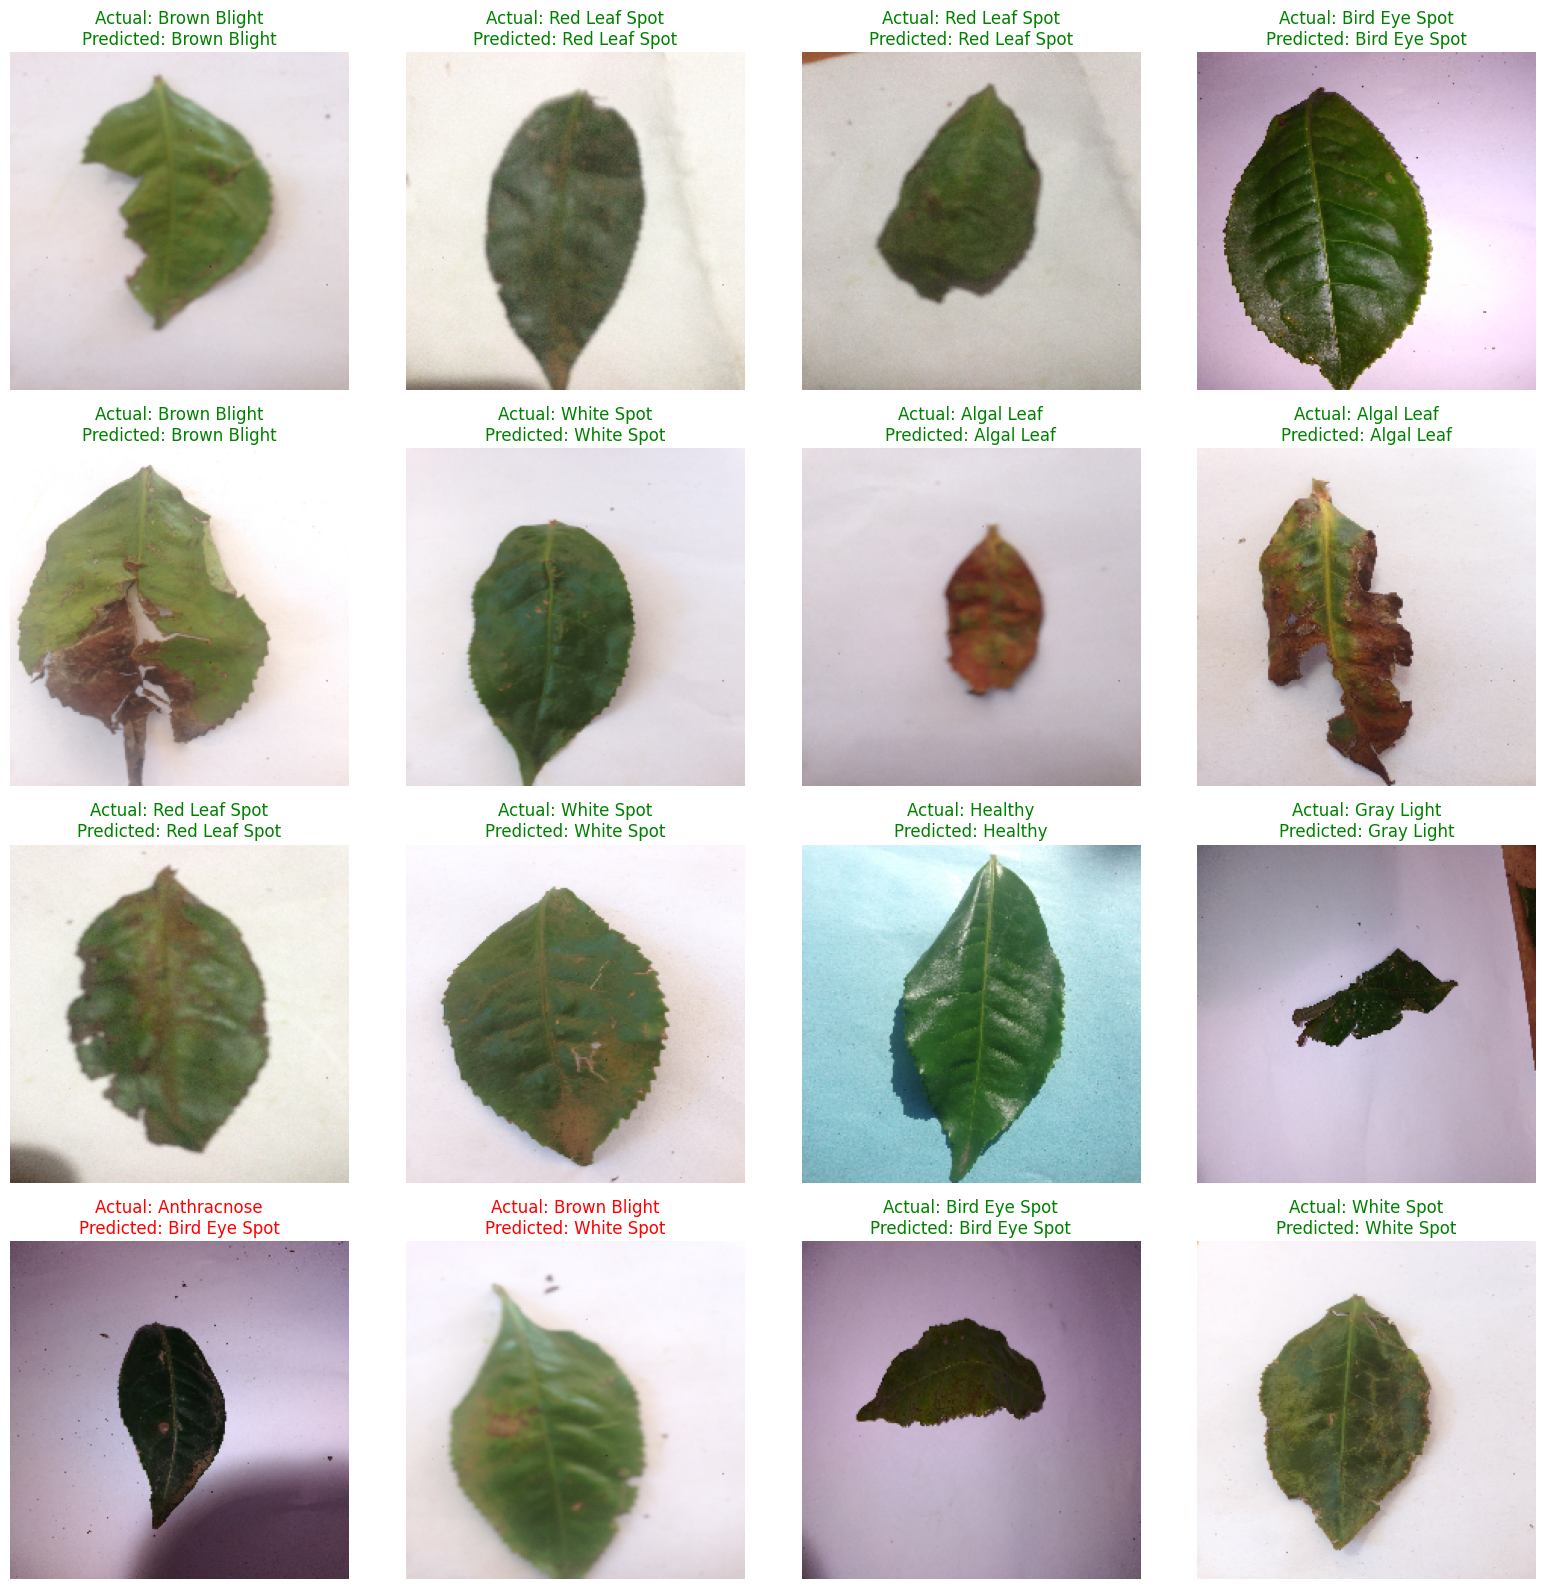

In [14]:
#@title Final Demo: Predict on 16 Random Images ▶️
# ==============================================================================
# Final Demonstration: Predict on a grid of 16 random test images
# ==============================================================================
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import random

# --- 1. SETUP ---
# Path to your BEST saved model in Google Drive
MODEL_PATH = '/content/artifacts/mobilenetv2_finetuned_model.h5'
# Path to your test images
TEST_DIR = "/content/tea_splits/test"

CLASS_NAMES = [
    'Algal Leaf', 'Anthracnose', 'Bird Eye Spot', 'Brown Blight',
    'Gray Light', 'Healthy', 'Red Leaf Spot', 'White Spot'
]
IMG_WIDTH, IMG_HEIGHT = 224, 224

# --- 2. LOAD THE TRAINED MODEL ---
try:
    print("Loading trained model from Google Drive...")
    model = tf.keras.models.load_model(MODEL_PATH)
    print(f"Model '{MODEL_PATH}' loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

# --- 3. SELECT, PREDICT, AND DISPLAY 16 IMAGES ---
if model is not None:
    # Get a list of all image paths in the test directory
    all_image_paths = []
    for class_folder in os.listdir(TEST_DIR):
        class_path = os.path.join(TEST_DIR, class_folder)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                all_image_paths.append(os.path.join(class_path, file_name))

    # Randomly select 16 images from the list
    random_image_paths = random.sample(all_image_paths, 16)

    # Create a 4x4 grid for displaying the images
    plt.figure(figsize=(16, 16))

    print("\nDisplaying predictions for 16 random test images...")
    print("Green = Correct Prediction, Red = Incorrect Prediction")

    # Loop through the 16 random images
    for i, image_path in enumerate(random_image_paths):
        # Create a subplot for each image
        ax = plt.subplot(4, 4, i + 1)

        # Load and preprocess the image
        img = image.load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
        img_array = image.img_to_array(img)
        img_array /= 255.0
        img_batch = np.expand_dims(img_array, axis=0)

        # Make a prediction
        predictions = model.predict(img_batch, verbose=0)
        predicted_index = np.argmax(predictions[0])
        predicted_class_name = CLASS_NAMES[predicted_index]

        # Get the actual class name from the folder path
        actual_class_name = os.path.basename(os.path.dirname(image_path))

        # Set title color based on correctness
        title_color = "green" if predicted_class_name == actual_class_name else "red"

        # Display the image and labels
        plt.imshow(img)
        plt.title(f"Actual: {actual_class_name}\nPredicted: {predicted_class_name}", color=title_color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

else:
    print("Cannot proceed with prediction as the model is not loaded.")

# **Predict on Your Own Image**

Loading trained model...


Model '/content/artifacts/mobilenetv2_finetuned_model.h5' loaded successfully.


Saving UNADJUSTEDNONRAW_thumb_8b.jpg to UNADJUSTEDNONRAW_thumb_8b.jpg

User uploaded file 'UNADJUSTEDNONRAW_thumb_8b.jpg'
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


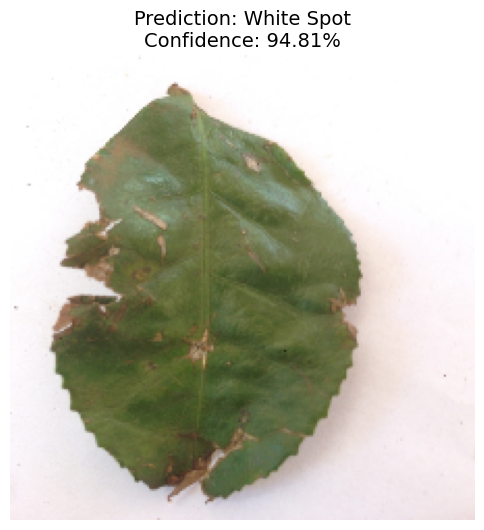

The model predicts this is a 'White Spot' leaf with 94.81% confidence.


In [15]:
#@title Step 8: Upload and Predict a New Image ▶️
# ==============================================================================
# Final Step: Evaluate a new, user-uploaded image
# ==============================================================================
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
from google.colab import files

# --- 1. SETUP ---
# Path to your saved model
MODEL_PATH = '/content/artifacts/mobilenetv2_finetuned_model.h5'
# The class names in the correct order
CLASS_NAMES = [
    'Algal Leaf', 'Anthracnose', 'Bird Eye Spot', 'Brown Blight',
    'Gray Light', 'Healthy', 'Red Leaf Spot', 'White Spot'
]
IMG_WIDTH, IMG_HEIGHT = 224, 224

# --- 2. LOAD THE TRAINED MODEL ---
try:
    print("Loading trained model...")
    model = tf.keras.models.load_model(MODEL_PATH)
    print(f"Model '{MODEL_PATH}' loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please make sure you have run the full training script first and the model file exists.")
    model = None

# --- 3. UPLOAD AND PREDICT ---
if model is not None:
    try:
        # Prompt user to upload an image
        uploaded = files.upload()

        # Get the first uploaded file
        for file_name in uploaded.keys():
            image_path = file_name
            print(f"\nUser uploaded file '{image_path}'")

            # Load and preprocess the image
            img = image.load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
            img_array = image.img_to_array(img)
            img_array /= 255.0
            img_batch = np.expand_dims(img_array, axis=0)

            # Make a prediction
            predictions = model.predict(img_batch)
            predicted_index = np.argmax(predictions[0])
            predicted_class_name = CLASS_NAMES[predicted_index]
            confidence = np.max(predictions[0]) * 100

            # Display the result
            plt.figure(figsize=(6, 7))
            plt.imshow(img)
            plt.title(f"Prediction: {predicted_class_name}\nConfidence: {confidence:.2f}%", fontsize=14)
            plt.axis('off')
            plt.show()

            print(f"The model predicts this is a '{predicted_class_name}' leaf with {confidence:.2f}% confidence.")

    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print("Cannot proceed with prediction as the model is not loaded.")